In [41]:
import pandas as pd
from io import StringIO
import chardet


In [111]:
import pandas as pd
from io import StringIO
import chardet
import numpy as np

# 检测文件编码
file_path = 'hotel.csv'
with open(file_path, 'rb') as file:
    result = chardet.detect(file.read())
encoding = result['encoding']
print(f"文件编码为：{encoding}")

# 加载文件
with open(file_path, 'r', encoding=encoding, errors='replace') as file:
    lines = file.readlines()
data = pd.read_csv(StringIO(''.join(lines)))

# 文本标准化函数
def normalize_text(text):
    if pd.isna(text):
        return text
    text = str(text).strip().lower()
    text = text.replace('Ãâ·ñ', '免费').replace('½¡ÉíÊÒ', '健身室')
    return text

# 应用文本标准化
data = data.applymap(lambda x: normalize_text(x) if isinstance(x, str) else x)

# 删除完全空的行
data.dropna(how='all', inplace=True)

# 转换价格和评分为数值型
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data['score'] = pd.to_numeric(data['score'], errors='coerce')

# 保留评分小数点后一位
data['score'] = data['score'].round(1)

# 清理评论列
data['comment'] = data['comment'].str.replace('条点评', '', regex=False).str.replace(',', '')
data['comment'] = pd.to_numeric(data['comment'], errors='coerce')

# 保留价格和评论列为整数
data['price'] = data['price'].round(0).astype('Int64')  # 转换为整数（支持缺失值）
data['comment'] = data['comment'].round(0).astype('Int64')  # 转换为整数（支持缺失值）

# 填充缺失值为 null
data = data.fillna(np.nan)

# 处理 address 列
data['address'] = data['address'].fillna('未知区域 | 未知距离')
data[['area', 'distance']] = data['address'].str.split('|', n=1, expand=True)

# 删除原有 address 列
data.drop(columns=['address'], inplace=True)

# 去除多余空格
data['area'] = data['area'].str.strip()
data['distance'] = data['distance'].str.strip()

# 提取 distance 中的数值并统一为千米
def extract_distance(distance):
    if pd.isna(distance):
        return np.nan
    distance = distance.lower().strip()
    # 提取数值部分（包括小数点）
    if '米' in distance:
        num = ''.join(filter(lambda x: x.isdigit() or x == '.', distance))  # 提取数字和小数点
        return round(float(num) / 1000, 1)  # 转换为千米，保留一位小数
    elif '公里' in distance or 'km' in distance:
        num = ''.join(filter(lambda x: x.isdigit() or x == '.', distance))  # 提取数字和小数点
        return round(float(num), 1)  # 直接保留为千米，保留一位小数
    elif any(char.isdigit() for char in distance):  # 如果有数字部分
        num = ''.join(filter(lambda x: x.isdigit() or x == '.', distance))  # 提取数字和小数点
        return round(float(num) / 1000, 1)  # 假定单位是米
    else:
        return np.nan

data['distance'] = data['distance'].apply(extract_distance)

#将所有空白字符串替换为 NaN
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#将所有缺失值（NaN）替换为 NaN（这一步是为了确保我们不丢失 NaN）
data = data.applymap(lambda x: np.nan if pd.isna(x) or (isinstance(x, str) and x.strip() == '') else x)


# 保存清理后的数据
data.to_csv('hotel_cleaned_normalized.csv', index=False, encoding='utf-8')
print("清洗完成！数据已保存为 'hotel_cleaned_normalized.csv'")


文件编码为：GB2312
清洗完成！数据已保存为 'hotel_cleaned_normalized.csv'


C:\Users\pc\AppData\Local\Temp\ipykernel_17056\3441615108.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: normalize_text(x) if isinstance(x, str) else x)


In [113]:
print(data.head())
print(data.info())


                     name condition  price  score  comment  \
1               香港富荟炮台山酒店      None    662    4.1     4139   
3               香港铜锣湾皇悦酒店      None    762    4.2     3869   
5               香港尖沙咀皇悦酒店      None    854    4.3     8078   
7                 香港维港湾酒店      None    691    3.9     1207   
9  香港天一酒店(尖沙咀地铁站店近b1口20米)      None    409    4.2      861   

                                                tags     area  distance  
1  ['健身室', '无烟楼层', '商务中心', '洗衣服务', '免费客房wifi', '会...  北角/��鱼涌       4.9  
3  ['行政酒廊', '无烟楼层', '海景房', '自助早餐', '咖啡厅', '商务中心',...   湾仔/铜锣湾       5.0  
5  ['海景房', '套房', '动人夜景', '自助早餐', '酒吧', '免费行李寄存', ...      尖沙咀       2.6  
7  ['免费客房wifi', '无烟楼层', '家庭房', '维港夜景', '下午茶', '咖啡...      尖沙咀       3.0  
9      ['无烟楼层', '家庭房', '免费客房wifi', '洗衣服务', '免费行李寄存']      尖沙咀       2.7  
<class 'pandas.core.frame.DataFrame'>
Index: 674 entries, 1 to 1347
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0 

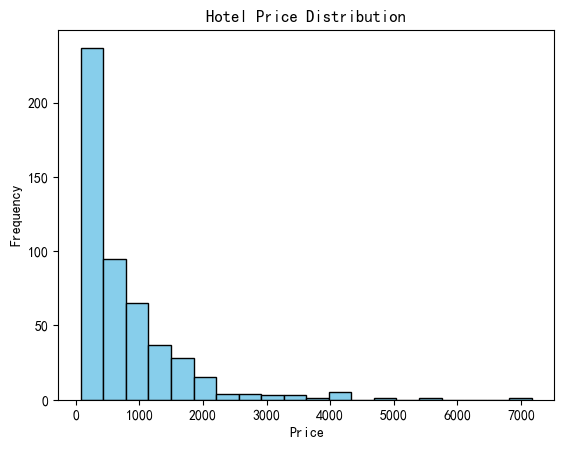

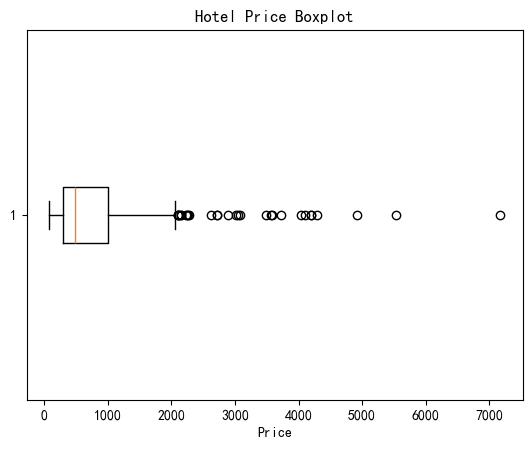

result：
平均值：788 元
中位数：481 元
价格范围：80 元 至 7170 元
第一四分位数 (Q1)：292 元
第三四分位数 (Q3)：1010 元
四分位距 (IQR)：718 元


In [163]:
import matplotlib.pyplot as plt

# 酒店价格分布直方图
plt.hist(data['price'], bins=20, edgecolor='k',color='skyblue')
plt.title('Hotel Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('Hotel Price Distribution.png', dpi=300, bbox_inches='tight') 
plt.show()

# 酒店价格箱形图
plt.boxplot(data['price'].dropna(), vert=False)
plt.title('Hotel Price Boxplot')
plt.xlabel('Price')

plt.savefig('Hotel Price Boxplot.png', dpi=300, bbox_inches='tight')  
plt.show()

# 数据统计分析
price_mean = data['price'].mean()
price_median = data['price'].median()
price_max = data['price'].max()
price_min = data['price'].min()
price_q1 = data['price'].quantile(0.25)
price_q3 = data['price'].quantile(0.75)
iqr = price_q3 - price_q1

print(f"result：")
print(f"平均值：{price_mean:.0f} 元")
print(f"中位数：{price_median:.0f} 元")
print(f"价格范围：{price_min:.0f} 元 至 {price_max:.0f} 元")
print(f"第一四分位数 (Q1)：{price_q1:.0f} 元")
print(f"第三四分位数 (Q3)：{price_q3:.0f} 元")
print(f"四分位距 (IQR)：{iqr:.0f} 元")


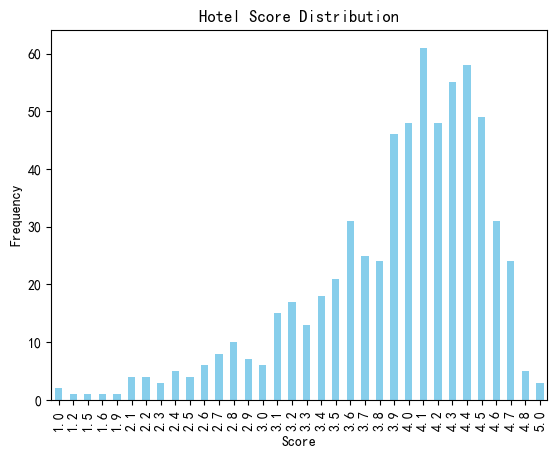

评分分析结果：
平均评分：3.9
中位评分：4.1
评分范围：1.0 至 5.0
评分标准差：0.63


In [165]:
# 酒店评分分布条形图
data['score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Hotel Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('Hotel Score Distribution.png', dpi=300, bbox_inches='tight')  
plt.show()

# 数据统计分析
score_mean = data['score'].mean()
score_median = data['score'].median()
score_min = data['score'].min()
score_max = data['score'].max()
score_std = data['score'].std()

print(f"评分分析结果：")
print(f"平均评分：{score_mean:.1f}")
print(f"中位评分：{score_median:.1f}")
print(f"评分范围：{score_min:.1f} 至 {score_max:.1f}")
print(f"评分标准差：{score_std:.2f}")

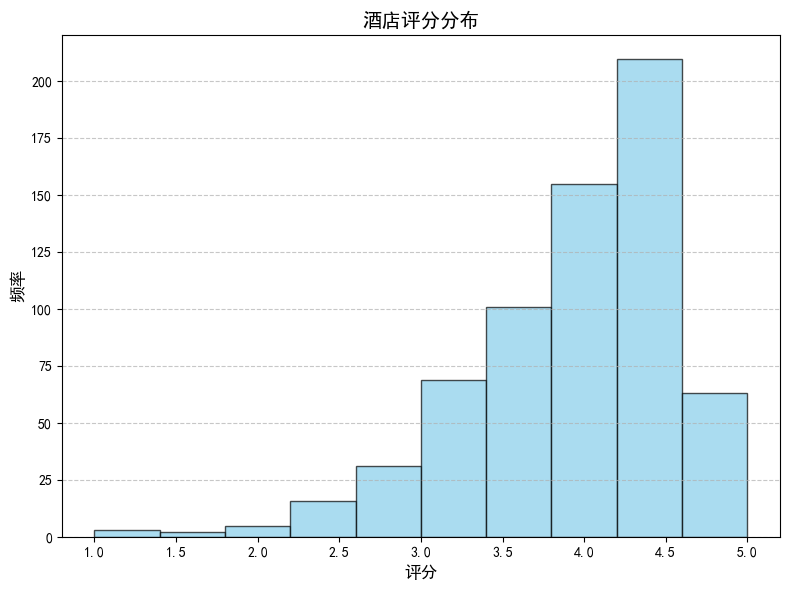

评分分析结果：
平均评分：3.9
中位评分：4.1
评分范围：1.0 至 5.0
评分标准差：0.63


In [157]:
import matplotlib.pyplot as plt

# 绘制酒店评分分布的直方图
plt.figure(figsize=(8, 6))
plt.hist(data['score'].dropna(), bins=10, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('酒店评分分布', fontsize=14)
plt.xlabel('评分', fontsize=12)
plt.ylabel('频率', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 数据统计分析
score_mean = data['score'].mean()
score_median = data['score'].median()
score_min = data['score'].min()
score_max = data['score'].max()
score_std = data['score'].std()

print(f"评分分析结果：")
print(f"平均评分：{score_mean:.1f}")
print(f"中位评分：{score_median:.1f}")
print(f"评分范围：{score_min:.1f} 至 {score_max:.1f}")
print(f"评分标准差：{score_std:.2f}")


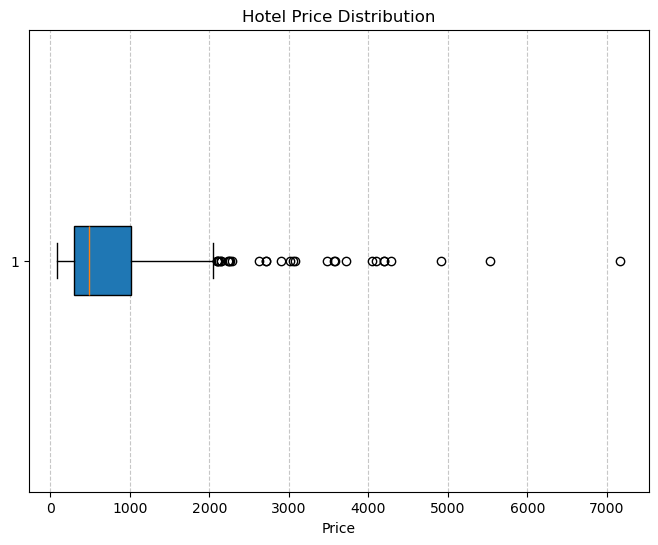

In [121]:
# 绘制价格的箱线图
plt.figure(figsize=(8, 6))
plt.boxplot(data['price'].dropna(), vert=False, patch_artist=True)
plt.title('Hotel Price Distribution')
plt.xlabel('Price')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


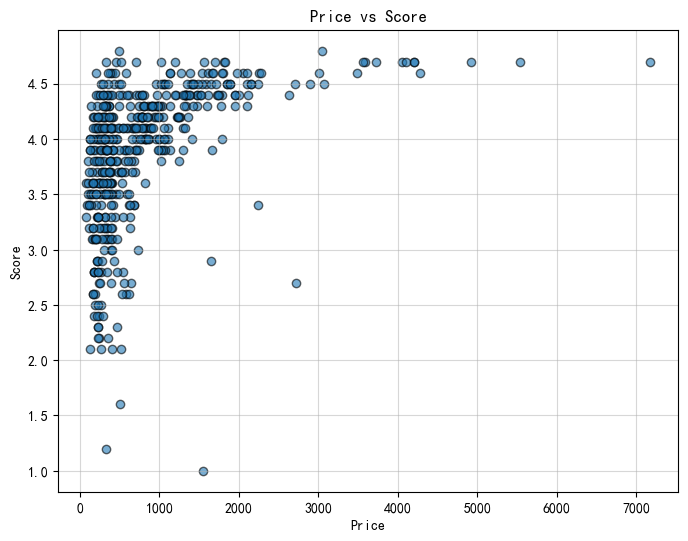

评分与价格的相关系数：0.45


In [171]:
# 绘制评分与价格的散点图
plt.figure(figsize=(8, 6))
plt.scatter(data['price'], data['score'], alpha=0.6, edgecolor='k')
plt.title('Price vs Score')
plt.xlabel('Price')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.savefig('Price vs Score.png', dpi=300, bbox_inches='tight')  
plt.show()

#计算相关系数
correlation = data[['price', 'score']].corr().iloc[0, 1]
print(f"评分与价格的相关系数：{correlation:.2f}")

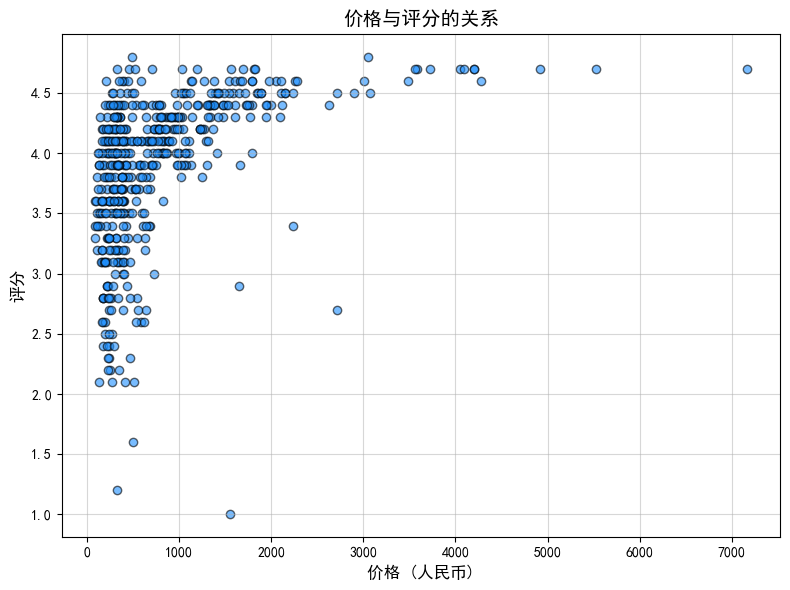

In [139]:
# 3. 酒店评分与价格关系分析
plt.figure(figsize=(8, 6))
plt.scatter(data['price'], data['score'], alpha=0.6, edgecolor='k', color='dodgerblue')
plt.title('价格与评分的关系', fontsize=14)
plt.xlabel('价格 (人民币)', fontsize=12)
plt.ylabel('评分', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

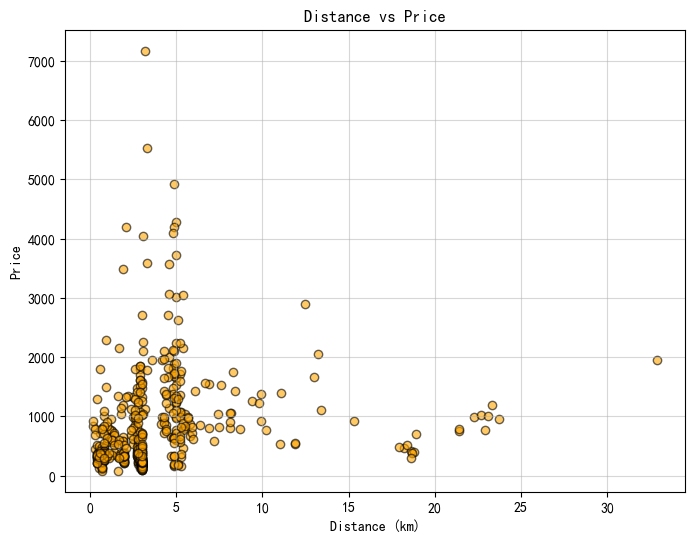

距离与价格的相关系数：0.45


In [175]:
# 绘制距离与价格的散点图
plt.figure(figsize=(8, 6))
plt.scatter(data['distance'], data['price'], alpha=0.6, edgecolor='k', color='orange')
plt.title('Distance vs Price')
plt.xlabel('Distance (km)')
plt.ylabel('Price')
plt.grid(alpha=0.5)
plt.savefig('Distance vs Price.png', dpi=300, bbox_inches='tight')  
plt.show()

#计算相关系数
correlation = data[['price', 'score']].corr().iloc[0, 1]
print(f"距离与价格的相关系数：{correlation:.2f}")

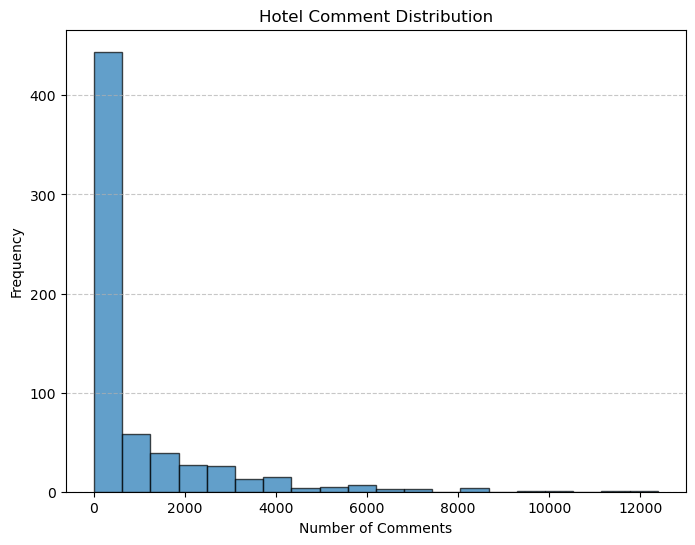

In [129]:
# 绘制评论数量的直方图
plt.figure(figsize=(8, 6))
plt.hist(data['comment'].dropna(), bins=20, edgecolor='black', alpha=0.7)
plt.title('Hotel Comment Distribution')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


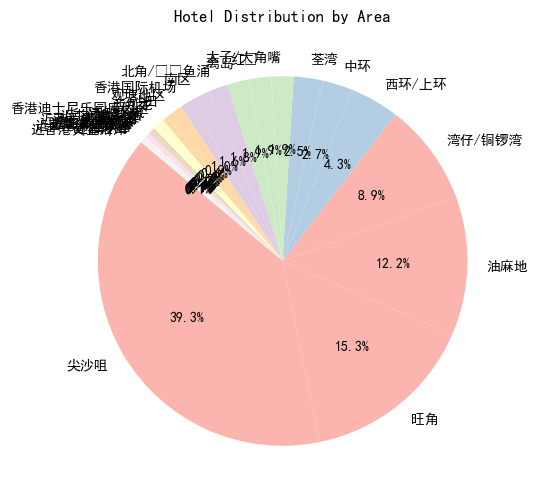

In [133]:
# 计算每个区域的酒店数量
import matplotlib.pyplot as plt

# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


area_counts = data['area'].value_counts()

# 绘制饼图
plt.figure(figsize=(8, 6))
area_counts.plot.pie(autopct='%1.1f%%', startangle=140, colormap='Pastel1')
plt.title('Hotel Distribution by Area')
plt.ylabel('')
plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_17056\3247019406.py:16: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  plt.tight_layout()
C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


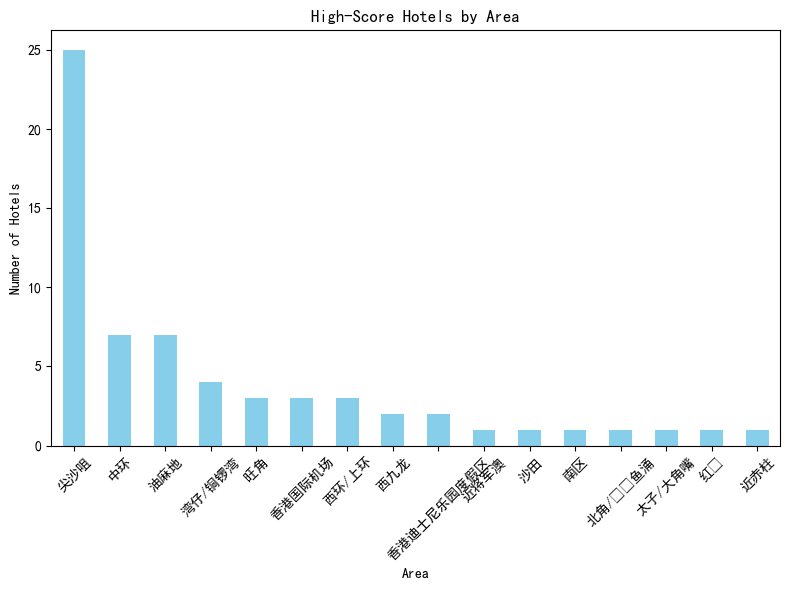

In [135]:
# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 筛选高评分酒店
high_score_hotels = data[data['score'] > 4.5]
high_score_area_counts = high_score_hotels['area'].value_counts()

# 绘制柱状图
plt.figure(figsize=(8, 6))
high_score_area_counts.plot(kind='bar', color='skyblue')
plt.title('High-Score Hotels by Area')
plt.xlabel('Area')
plt.ylabel('Number of Hotels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_17056\1404871150.py:11: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  plt.tight_layout()
C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


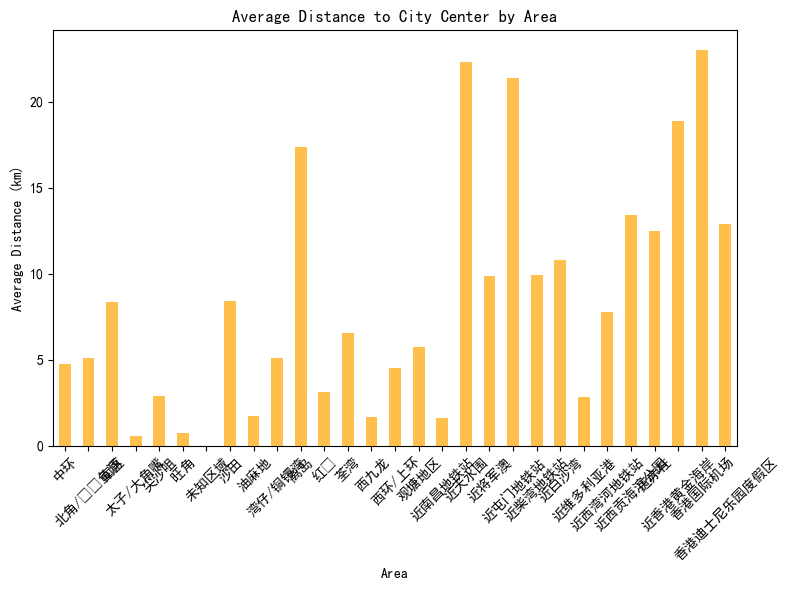

In [137]:
# 计算每个区域的平均距离
avg_distance_by_area = data.groupby('area')['distance'].mean()

# 绘制柱状图
plt.figure(figsize=(8, 6))
avg_distance_by_area.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Average Distance to City Center by Area')
plt.xlabel('Area')
plt.ylabel('Average Distance (km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
